## Downloading Data From Kaggle

In [ ]:
! pip install kaggle

In [ ]:
mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download yousefmohamed20/sentiment-images-classifier

Dataset URL: https://www.kaggle.com/datasets/yousefmohamed20/sentiment-images-classifier
License(s): Apache 2.0
 90% 103M/114M [00:01<00:00, 115MB/s]  
100% 114M/114M [00:01<00:00, 91.8MB/s]


In [ ]:
! unzip /content/sentiment-images-classifier.zip

Archive:  /content/sentiment-images-classifier.zip
  inflating: 6 Emotions for image classification/anger/-win-holding-his-fists-shout-wow-mature-hispanic-man-happy-his-win-122652456.jpg  
  inflating: 6 Emotions for image classification/anger/GBP-scam.jpg  
  inflating: 6 Emotions for image classification/anger/I-hate-my-job.jpeg  
  inflating: 6 Emotions for image classification/anger/Learn-How-to-Protect-Yourself-from-Aggressive-Drivers-on-the-Road-1024x683.jpg  
  inflating: 6 Emotions for image classification/anger/OIP.0846U2L7OhuSwKhrPv2QyAHaE8.jpg  
  inflating: 6 Emotions for image classification/anger/OIP.2U-VMhf313UA984u5UOmFgHaE8.jpg  
  inflating: 6 Emotions for image classification/anger/OIP.4KY2OX8QTAff8PFMslU-rQHaFU.jpg  
  inflating: 6 Emotions for image classification/anger/OIP.5HgV6R-8EQ-LPrPMTjVxJwHaLH.jpg  
  inflating: 6 Emotions for image classification/anger/OIP.6t0EWZ09nvNTr_GNGp-zKwAAAA.jpg  
  inflating: 6 Emotions for image classification/anger/OIP.Bfvrze8Og2

## Loading Data

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# ! unzip -q /content/drive/MyDrive/sentiment-images-classifier.zip -d /content/drive/MyDrive/

In [30]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [31]:
data_dir = '/content/drive/MyDrive/6 Emotions for image classification'

In [32]:
# Step 2: Define transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [33]:
# Step 3: Create the dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Step 4: Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to the validation set
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader for train and val sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
class_names

['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Step 5: Load a pre-trained model and modify it
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Step 6: Train the model
num_epochs = 25

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()

print('Training complete')

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/emotion_classification_model.pth')

Epoch 0/24
----------
train Loss: 1.6695 Acc: 0.3184
val Loss: 1.4711 Acc: 0.4083

Epoch 1/24
----------
train Loss: 1.1420 Acc: 0.6326
val Loss: 1.2444 Acc: 0.5417

Epoch 2/24
----------
train Loss: 0.8325 Acc: 0.7641
val Loss: 1.1375 Acc: 0.5625

Epoch 3/24
----------
train Loss: 0.6034 Acc: 0.8445
val Loss: 1.0156 Acc: 0.6042

Epoch 4/24
----------
train Loss: 0.4466 Acc: 0.8977
val Loss: 0.9904 Acc: 0.6167

Epoch 5/24
----------
train Loss: 0.3113 Acc: 0.9541
val Loss: 0.9502 Acc: 0.6375

Epoch 6/24
----------
train Loss: 0.2216 Acc: 0.9749
val Loss: 0.9446 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.1786 Acc: 0.9812
val Loss: 0.9380 Acc: 0.6667

Epoch 8/24
----------
train Loss: 0.1674 Acc: 0.9906
val Loss: 0.9360 Acc: 0.6625

Epoch 9/24
----------
train Loss: 0.1555 Acc: 0.9885
val Loss: 0.9320 Acc: 0.6625

Epoch 10/24
----------
train Loss: 0.1582 Acc: 0.9843
val Loss: 0.9359 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.1553 Acc: 0.9823
val Loss: 0.9333 Acc: 0.6667

Ep

Predicted class: happy


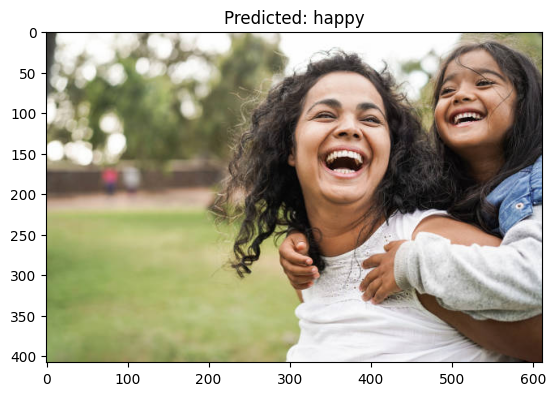

In [38]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Define the class names and transformations
class_names = ['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Step 2: Load the trained model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/emotion_classification_model.pth'))
model.eval()

# Step 3: Preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = data_transforms(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Step 4: Run inference
def predict(image_path):
    image = preprocess_image(image_path)
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    return class_names[preds[0]]

# Provide the path to the image you want to classify
image_path = '/content/drive/MyDrive/happy_image_stockphoto.jpg'  # Change this to your image path
predicted_class = predict(image_path)
print(f'Predicted class: {predicted_class}')

# Optional: Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted: {predicted_class}')
plt.show()